# Fesabilité classification des images


## Import des librairies


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import ast
import time
from matplotlib.image import imread
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    GlobalAveragePooling1D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Import des données


In [2]:
df_product_clean = pd.read_csv("dataset/Flipkart/flipkart_clean.csv")


# Create a function for split the first category
def extract_words_category(chaine):
    liste = ast.literal_eval(chaine)
    return liste[0].split(">>")[0]


# Apply function to a new column
df_product_clean["first_category"] = df_product_clean["product_category_tree"].apply(
    extract_words_category
)
df_product_clean["first_category"] = df_product_clean["first_category"].str.rstrip()
df_product_clean.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,first_category
0,55b85ea15a1536d46b7190ad6fff8ce7,30-04-2016 03:22:56,http://www.flipkart.com/elegance-polyester-mul...,elegance polyester multicolor abstract eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,key feature elegance polyester multicolor abst...,No rating available,No rating available,Elegance,"{'product_specification': [{'key': 'Brand', 'v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,30-04-2016 03:22:56,http://www.flipkart.com/sathiyas-cotton-bath-t...,sathiyas cotton bath towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,specification sathiyas cotton bath towel bath ...,No rating available,No rating available,Sathiyas,{'product_specification': [{'key': 'Machine Wa...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,30-04-2016 03:22:56,http://www.flipkart.com/eurospa-cotton-terry-f...,eurospa cotton terry face towel set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,999.0,600.0,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,key feature eurospa cotton terry face towel se...,No rating available,No rating available,Eurospa,"{'product_specification': [{'key': 'Material',...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,20-06-2016 08:49:52,http://www.flipkart.com/santosh-royal-fashion-...,santosh royal fashion cotton printed king size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,key feature santosh royal fashion cotton print...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{'product_specification': [{'key': 'Brand', 'v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,20-06-2016 08:49:52,http://www.flipkart.com/jaipur-print-cotton-fl...,jaipur print cotton floral king sized double b...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,key feature jaipur print cotton floral king si...,No rating available,No rating available,Jaipur Print,{'product_specification': [{'key': 'Machine Wa...,Home Furnishing


## classification automatique d’images via SIFT


### Ajout des labels pour chaque images


In [6]:
# add path folder image to images column
path_folder_image = "dataset/Flipkart/Images/"
df_product_clean["image"] = path_folder_image + df_product_clean["image"].astype(str)
# Create label encoder for each categories in dataframe
le = preprocessing.LabelEncoder()
le.fit(df_product_clean["first_category"])
df_product_clean["label"] = le.transform(df_product_clean["first_category"])
df_product_clean["label"] = le.transform(df_product_clean["first_category"])

### Verification des categories par images


In [4]:
df_product_clean["first_category"].value_counts()

first_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

Nos categories qui seront nos label pour la classification sont bien répartie


### Pré-visualisation des images en fonction de leurs labels


Home Furnishing


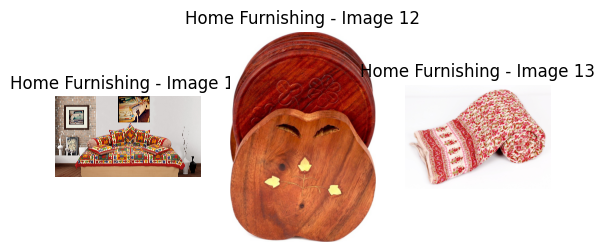

Baby Care


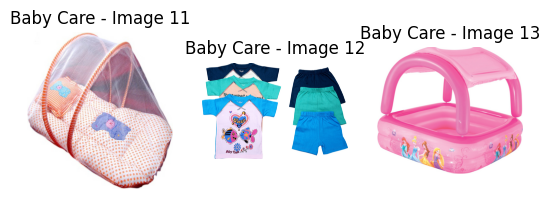

Watches


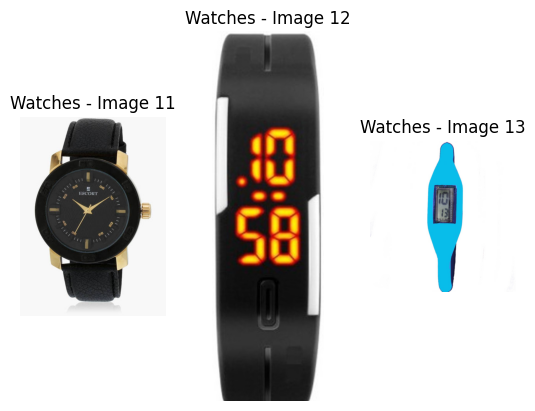

Home Decor & Festive Needs


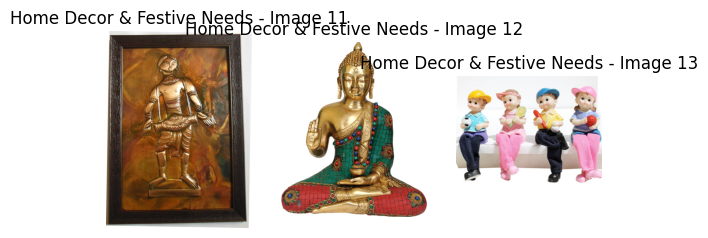

Kitchen & Dining


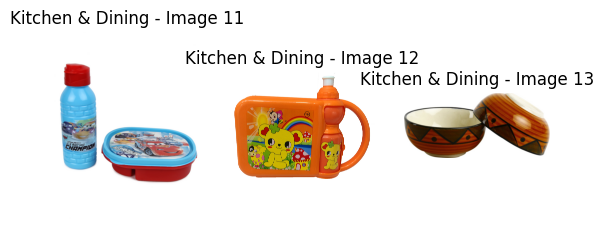

Beauty and Personal Care


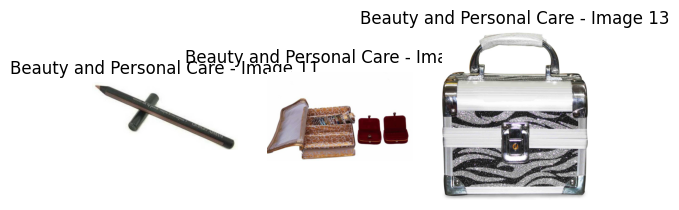

Computers


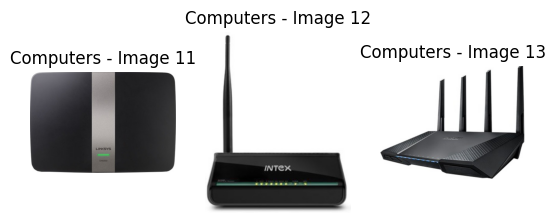

In [5]:
list_labels = df_product_clean["first_category"].unique()


# Create a function for match image with label
def list_fct(name):
    list_image_name = [
        df_product_clean["image"][i]
        for i in range(len(df_product_clean))
        if df_product_clean["first_category"][i] == name
    ]
    return list_image_name


list_home = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Home Furnishing"
]
list_baby = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Baby Care"
]
list_watches = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Watches"
]
list_home_decor = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Home Decor & Festive Needs"
]

list_kitchen = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Kitchen & Dining"
]
list_beauty = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Beauty and Personal Care"
]

list_beauty = [
    df_product_clean["image"][i]
    for i in range(len(df_product_clean))
    if df_product_clean["first_category"][i] == "Computers"
]

for name in list_labels:
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        filename = list_fct(name)[i + 10]
        image = imread(filename)
        plt.axis("off")
        plt.imshow(image)
        plt.title(f"{name} - Image {i + 11}")
    plt.show()

### Classification des images (algorithme SIFT)


#### Pré-traitement sur une image : Détermination et affichage des descripteurs SIFT


dataset/Flipkart/Images/63bc43c0000e71eb11bfafd2f46214a4.jpg
Descripteurs :  (1430, 128)

[[  1.   0.   0. ...   0.   0.   1.]
 [  1.  68. 140. ...   0.   0.   0.]
 [  0. 149. 102. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  52.   1.   1.]
 [  1.   1.   1. ...  89.   1.   5.]]


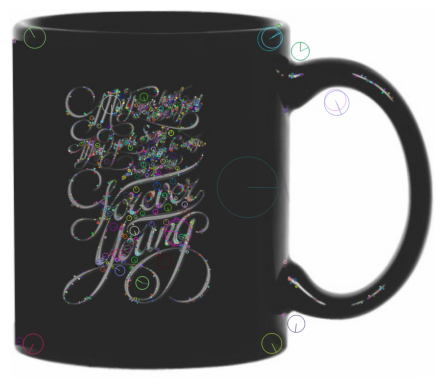

In [6]:
# display descriptor SIFT
test_image_path = df_product_clean.image.sample().values[0]
sift = cv2.SIFT_create()
print(test_image_path)
image_test = cv2.imread(test_image_path)
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)

kp, descript = sift.detectAndCompute(image_test, None)
img = img = cv2.drawKeypoints(
    image_test, kp, image_test, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
plt.axis("off")
plt.imshow(img)
print("Descripteurs : ", descript.shape)
print()
print(descript)

#### Prétraitement de chaque images


On va va convertir chaque image en gris création d'une function a appliquer sur nos images


In [7]:
def preprocessing_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur de chargement de l'image : {image_path}")
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    return gray

In [8]:
df_product_clean["image_preprocessing"] = df_product_clean["image"].apply(
    lambda x: preprocessing_image(x)
)

#### Création des descripteurs et cluster pour chaque image


In [9]:
# Initialiser SIFT avec un nombre maximum de points clés
n_features = 500  # Réduire pour limiter les descripteurs
sift = cv2.SIFT_create(nfeatures=n_features)

# Définir le nombre de clusters (visual words) et la taille du batch
num_clusters = 300  # Exemple : 100 visual words
batch_size = 10000  # Nombre total de descripteurs par batch

# Initialiser MiniBatchKMeans
kmeans = MiniBatchKMeans(
    n_clusters=num_clusters, random_state=42, batch_size=batch_size
)

# Enregistrer le temps de début
temps1 = time.time()

# Initialiser la liste pour stocker tous les descripteurs
sift_keypoints = []

# Utiliser tqdm pour suivre la progression
for i, image_file in enumerate(
    tqdm(df_product_clean["image"], desc="Traitement des images")
):
    if i % 100 == 0:
        print(f"Traitement de l'image {i+1}/{len(df_product_clean)}")

    # Lire l'image
    image = cv2.imread(image_file)
    if image is None:
        print(f"Erreur de chargement de l'image : {image_file}")
        continue  # Passer à l'image suivante

    # Convertir en niveaux de gris
    try:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except Exception as e:
        print(
            f"Erreur de conversion en niveaux de gris pour l'image {image_file} : {e}"
        )
        continue  # Passer à l'image suivante

    # Optionnel : égaliser l'histogramme pour améliorer le contraste
    gray_image = cv2.equalizeHist(gray_image)

    # Optionnel : Redimensionner l'image pour réduire la taille
    desired_size = (300, 300)  # Ajustez selon vos besoins
    gray_image = cv2.resize(gray_image, desired_size)

    # Détecter les points clés et calculer les descripteurs
    kp, des = sift.detectAndCompute(gray_image, None)

    # Vérifier si des descripteurs ont été trouvés
    if des is not None:
        sift_keypoints.append(des)

    # Calculer le nombre total de descripteurs dans le batch
    current_batch_size = sum(len(d) for d in sift_keypoints)

    # Lorsque la taille du batch est atteinte, entraîner MiniBatchKMeans
    if current_batch_size >= batch_size:
        # Empiler les descripteurs en un seul tableau
        try:
            all_descriptors = np.vstack(sift_keypoints)
        except ValueError as ve:
            print(f"Erreur lors de l'empilement des descripteurs : {ve}")
            continue

        # Entraîner MiniBatchKMeans avec les descripteurs du batch
        kmeans.partial_fit(all_descriptors)

# Traiter les descripteurs restants après la boucle
if sift_keypoints:
    try:
        all_descriptors = np.vstack(sift_keypoints)
        kmeans.partial_fit(all_descriptors)
    except ValueError as ve:
        print(f"Erreur lors de l'empilement des descripteurs restants : {ve}")

# Obtenir les centres de clusters (visual words)
visual_words = kmeans.cluster_centers_

# Calculer la durée
duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", f"{duration1:.2f}", "secondes")
print("Nombre de clusters (visual words) : ", visual_words.shape[0])

Traitement des images:   0%|          | 1/1050 [00:00<02:50,  6.16it/s]

Traitement de l'image 1/1050


Traitement des images:  10%|▉         | 102/1050 [00:05<00:53, 17.75it/s]

Traitement de l'image 101/1050


Traitement des images:  19%|█▉        | 200/1050 [00:12<01:18, 10.84it/s]

Traitement de l'image 201/1050


Traitement des images:  29%|██▊       | 301/1050 [00:25<01:51,  6.74it/s]

Traitement de l'image 301/1050


Traitement des images:  38%|███▊      | 401/1050 [00:40<02:01,  5.35it/s]

Traitement de l'image 401/1050


Traitement des images:  48%|████▊     | 500/1050 [00:58<01:48,  5.07it/s]

Traitement de l'image 501/1050


Traitement des images:  57%|█████▋    | 600/1050 [01:20<01:45,  4.28it/s]

Traitement de l'image 601/1050


Traitement des images:  67%|██████▋   | 700/1050 [01:53<02:05,  2.79it/s]

Traitement de l'image 701/1050


Traitement des images:  76%|███████▌  | 800/1050 [02:27<01:29,  2.81it/s]

Traitement de l'image 801/1050


Traitement des images:  86%|████████▌ | 900/1050 [03:08<00:52,  2.84it/s]

Traitement de l'image 901/1050


Traitement des images:  95%|█████████▌| 1000/1050 [03:49<00:21,  2.29it/s]

Traitement de l'image 1001/1050


Traitement des images: 100%|██████████| 1050/1050 [04:11<00:00,  4.17it/s]


Temps de traitement SIFT descriptor :  252.47 secondes
Nombre de clusters (visual words) :  300


In [10]:
print("Nombre de descripteurs : ", all_descriptors.shape)

Nombre de descripteurs :  (410039, 128)


#### Création des features d'images


In [11]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(visual_words))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de création des histogrammes :             0.86 secondes


In [12]:
im_features.shape

(1050, 300)

#### Réduction des dimmension ACP


In [13]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
acp = PCA(n_components=0.99)
X_img_acp = acp.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", X_img_acp.shape)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 255)


#### Analyse visuel via T-SNE

##### affichage T-SNE selon catégories d'images

/usr/local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


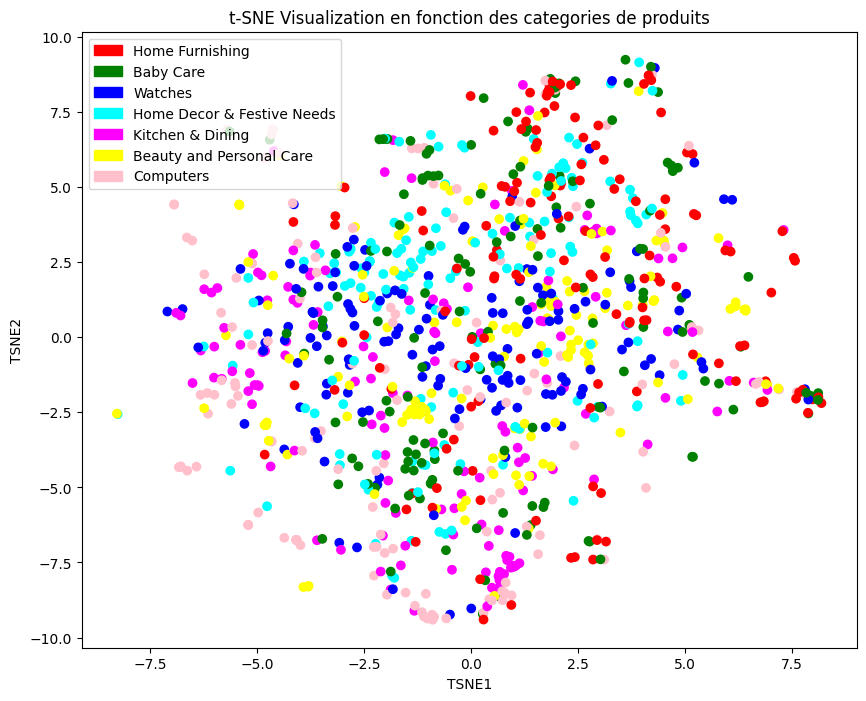

In [14]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_img_acp)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_img"] = tsne_results[:, 0]
df_product_clean["TSNE2_category_img"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_img"],
    df_product_clean["TSNE2_category_img"],
    c=color_list,
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

##### Affichage des images selon les clusters 

In [15]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

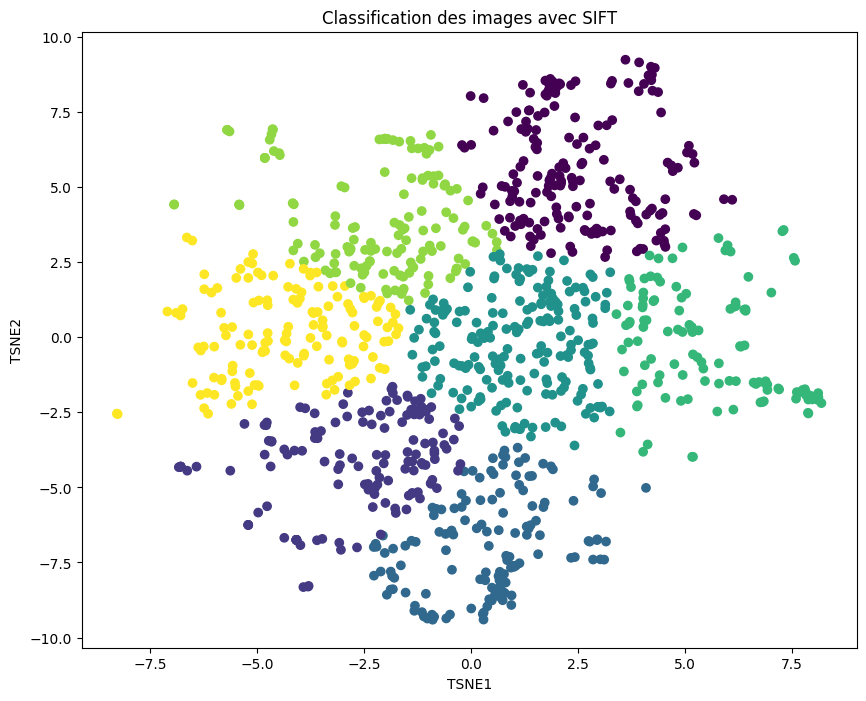

In [16]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["cluster_img_sift"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_sift"] = tsne_results[:, 0]
df_product_clean["TSNE2_sift"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_sift"],
    df_product_clean["TSNE2_sift"],
    c=df_product_clean["cluster_img_sift"],
)
plt.title("Classification des images avec SIFT")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [17]:
clusters_labels = kmeans.labels_

In [18]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec SIFT : {ari}")

Adjusted Rand Index (ARI) avec SIFT : 0.04989467238441309


### Approche CNN Transfert Learning avec VGG-16 

Pour des raisons d'incomptabilité matériel, nous allons créer un container pour faire tourner un conteneur avec tensorflow

#### Création du modèle VGG16


In [19]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

2024-11-03 10:47:44.640057: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-03 10:47:44.791333: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-11-03 10:47:44.943874: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-11-03 10:47:45.064686: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-11-03 10:47:45.426856: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2024-11-03 10:47:45.448126: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Création des features d'images

In [20]:
import tensorflow as tf


# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print CUDA and cuDNN versions
print(
    "Num GPUs Available: ",
    len(tf.config.experimental.list_physical_devices("GPU")),
)
print("CUDA Version: ", tf.test.is_built_with_cuda())
print("GPU Device Name: ", tf.test.gpu_device_name())

TensorFlow version: 2.18.0
Num GPUs Available:  0
CUDA Version:  True
GPU Device Name:  


In [21]:
images_features = []
i = 0
for image_file in df_product_clean["image"]:
    if i % 100 == 0:
        print(i)
    i += 1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(
        model.predict(image, verbose=0)[0]
    )  # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0


/usr/local/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


100
200
300
400
500
600


/usr/local/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

In [22]:
images_features.shape

(1050, 4096)

#### Réduction des dimmension ACP


In [23]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
acp = PCA(n_components=0.99)
X_img_acp = acp.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", X_img_acp.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


#### Analyse visuel via T-SNE

##### affichage T-SNE selon catégories d'images

/usr/local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


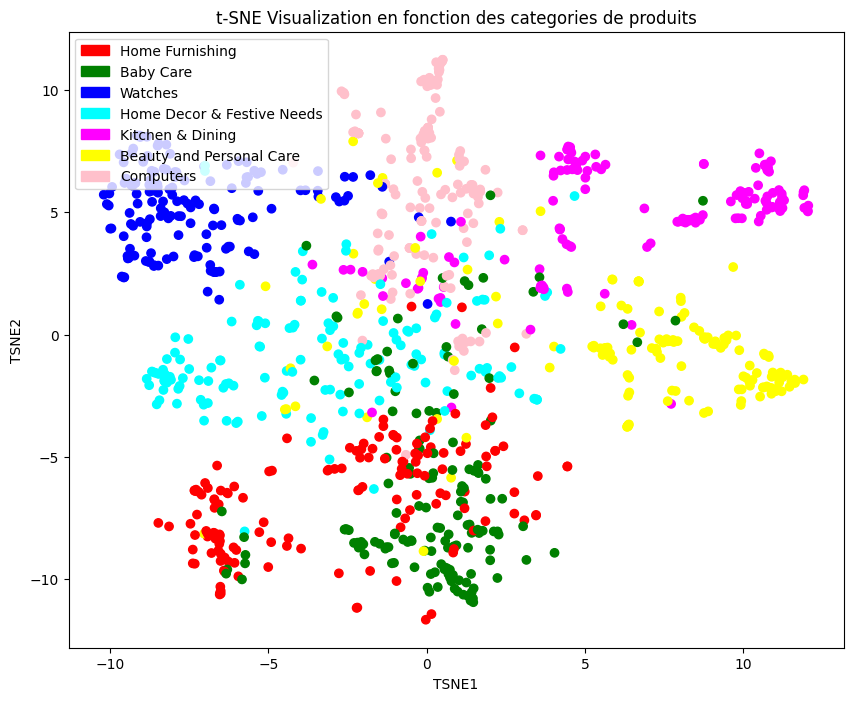

In [24]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_img_acp)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_img"] = tsne_results[:, 0]
df_product_clean["TSNE2_category_img"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_img"],
    df_product_clean["TSNE2_category_img"],
    c=color_list,
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

##### Affichage des images selon les clusters 

In [25]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

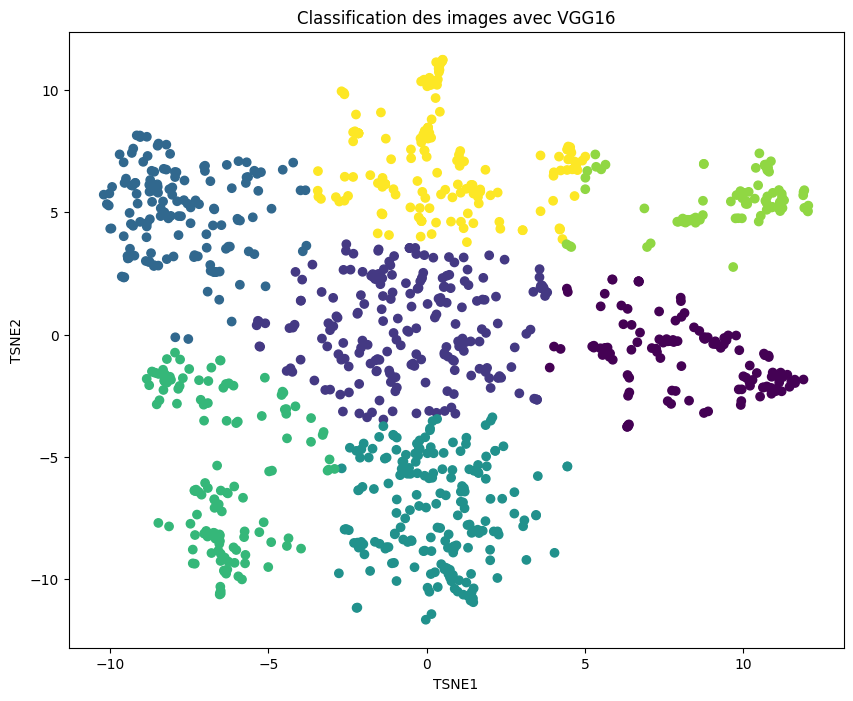

In [26]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["cluster_img_vgg16"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_vgg16"] = tsne_results[:, 0]
df_product_clean["TSNE2_vgg16"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_vgg16"],
    df_product_clean["TSNE2_vgg16"],
    c=df_product_clean["cluster_img_vgg16"],
)
plt.title("Classification des images avec VGG16")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [27]:
clusters_labels = kmeans.labels_

In [28]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec VGG16 : {ari}")

Adjusted Rand Index (ARI) avec VGG16 : 0.46202375691360603


### Approche CNN Transfert Learning et data augmentation (feature averaing ) avec VGG-16 

La data augmentation est une technique pour augmenter artificiellement la taille et la diversité de notre dataset d'image. Cette méthode consiste à appliquer diverses transformations aléatoire (rotation,zoom,miroir...) aux d'oriigne pour créer de nouvelles ce qui aide le modèle à mieux généraliser.
Dans cette partie nous allons utiliser la data augmentation avec le modèle pré-entrainer vgg16, est créer des 'images augmenté' qui va nous permettre d'obtenir plus de caractéristiques sur nos images d'origine 

In [52]:
import tensorflow as tf


# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print CUDA and cuDNN versions
print(
    "Num GPUs Available: ",
    len(tf.config.experimental.list_physical_devices("GPU")),
)
print("CUDA Version: ", tf.test.is_built_with_cuda())
print("GPU Device Name: ", tf.test.gpu_device_name())

TensorFlow version: 2.18.0
Num GPUs Available:  0
CUDA Version:  True
GPU Device Name:  


#### Création du modèle VGG16


In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


#### Récupération des features avec la data augmentation

dans ce code nous allons créer 5 images générer aléatoirement pour chaque images des produits pour en récupérer ces caractéristiques et faire un moyenne des caractéristique de ces images

In [56]:
# Configurer ImageDataGenerator pour la data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotate images up to ±20 degrees
    width_shift_range=0.1,     # Shift images horizontally by up to 10%
    height_shift_range=0.1,    # Shift images vertically by up to 10%
    shear_range=0.15,          # Shear images randomly
    zoom_range=0.1,            # Zoom images randomly by up to 10%
    horizontal_flip=True,      # Flip images horizontally
    fill_mode="nearest"        # Fill missing pixels after transformation
)

images_features = []
i = 0

# Configuration for the number of augmentations per image
num_augmentations = 5

for image_file in df_product_clean["image"]:
    if i % 100 == 0:
        print(f"Processing image {i}")
    i += 1

    # Load and preprocess the image
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Use ImageDataGenerator to create augmented images
    aug_iter = datagen.flow(image, batch_size=1)

    # Store features of the augmentations for a single image
    aug_features = []

    for j in range(num_augmentations):
        aug_image = next(aug_iter)[0]
        aug_image = np.expand_dims(aug_image, axis=0)
        aug_image = preprocess_input(aug_image)
        features = model.predict(aug_image, verbose=0)[0]
        aug_features.append(features)

    # Calculate the average of features from augmentations
    mean_features = np.mean(aug_features, axis=0)
    images_features.append(mean_features)

# Convert the list of features to a NumPy array
images_features = np.asarray(images_features)
print("Shape of features after averaging:", images_features.shape)

Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600


/usr/local/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Shape of features after averaging: (1050, 4096)


#### Réduction des dimmension ACP


In [57]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
acp = PCA(n_components=0.99)
X_img_acp = acp.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", X_img_acp.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 782)


#### Analyse visuel via T-SNE

##### affichage T-SNE selon catégories d'images

/usr/local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


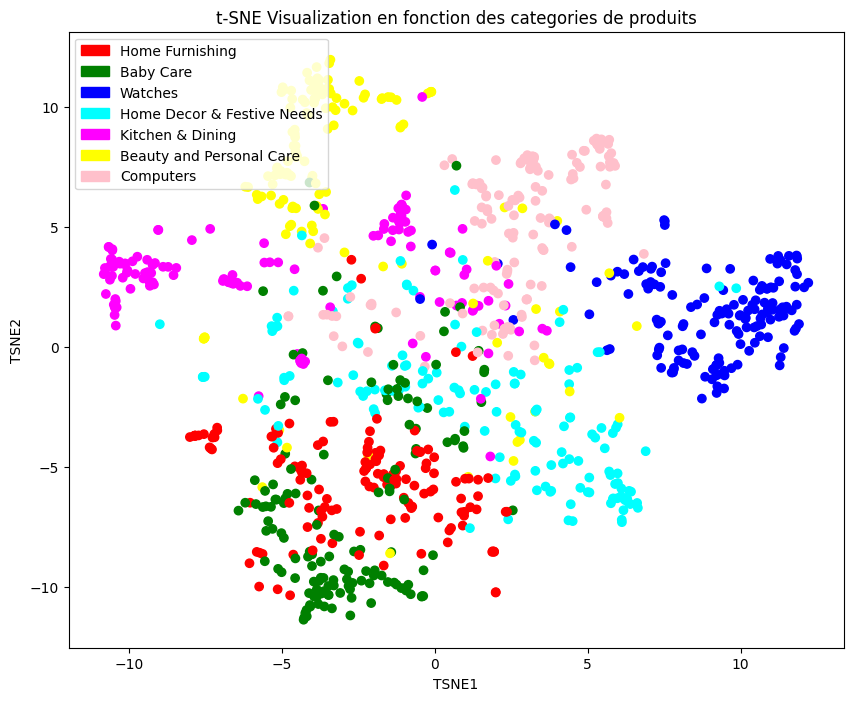

In [58]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_img_acp)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_img_augmentation"] = tsne_results[:, 0]
df_product_clean["TSNE2_category_img_augmentation"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_img_augmentation"],
    df_product_clean["TSNE2_category_img_augmentation"],
    c=color_list,
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

##### Affichage des images selon les clusters 

In [59]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

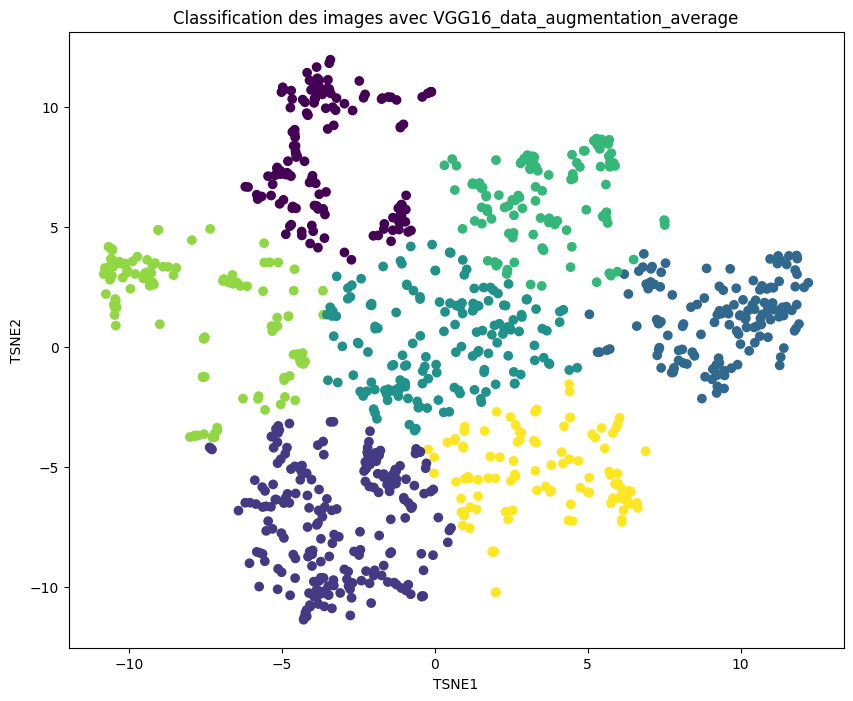

In [60]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["cluster_img_vgg16_data_augmentation_average"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_vgg16_data_augmentation_average"] = tsne_results[:, 0]
df_product_clean["TSNE2_vgg16_data_augmentation_average"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_vgg16_data_augmentation_average"],
    df_product_clean["TSNE2_vgg16_data_augmentation_average"],
    c=df_product_clean["cluster_img_vgg16_data_augmentation_average"],
)
plt.title("Classification des images avec VGG16_data_augmentation_average")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [61]:
clusters_labels = kmeans.labels_

In [62]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec VGG16 avec data augmentation : {ari}")

Adjusted Rand Index (ARI) avec VGG16 avec data augmentation : 0.4514739213530769


### Approche CNN Transfert Learning et data augmentation (fine-tuning) avec VGG-16 

#### Création des features d'images

In [3]:
import tensorflow as tf


# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print CUDA and cuDNN versions
print(
    "Num GPUs Available: ",
    len(tf.config.experimental.list_physical_devices("GPU")),
)
print("CUDA Version: ", tf.test.is_built_with_cuda())
print("GPU Device Name: ", tf.test.gpu_device_name())

TensorFlow version: 2.18.0
Num GPUs Available:  0
CUDA Version:  True
GPU Device Name:  


2024-11-03 16:22:18.215543: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#### Création d'un dataset avec data augmentation 

In [7]:
# CONFIG ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,         # Rotate images up to ±20 degrees
    width_shift_range=0.1,     # Shift images horizontally by up to 10%
    height_shift_range=0.1,    # Shift images vertically by up to 10%
    shear_range=0.15,          # Shear images randomly
    zoom_range=0.1,            # Zoom images randomly by up to 10%
    horizontal_flip=True,      # Flip images horizontally
    fill_mode="nearest"        # Fill missing pixels after transformation
)

# Répertoire pour sauvegarder les images augmentées
output_dir = "augmented_images"
os.makedirs(output_dir, exist_ok=True)


augmented_data = []


i = 0
for image_file in df_product_clean["image"]:
    if i % 100 == 0:
        print(f"Processing image {i}")
    i += 1

    # Load image 
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    # Use ImageDataGenerator for create augmented images
    aug_iter = datagen.flow(image, batch_size=1)

    # Generate and save augmented img
    for j in range(5): 
        aug_image = next(aug_iter)[0]
        aug_image = np.uint8(aug_image) 

        # Save image 
        augmented_image_path = os.path.join(output_dir, f"aug_image_{i}_{j}.jpg")
        plt.imsave(augmented_image_path, aug_image)

        # append information about image to dataframe
        augmented_data.append({
            "original_image": image_file,
            "augmented_image_path": augmented_image_path,
            "augmentation_index": j,
            "label": df_product_clean.loc[df_product_clean["image"] == image_file, "label"].values[0],
            "first_category": df_product_clean.loc[df_product_clean['image']== image_file,"first_category"].values[0]


        })

# Créer le DataFrame avec les images augmentées
df_augmented_images = pd.DataFrame(augmented_data)


Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600


/usr/local/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 700
Processing image 800
Processing image 900
Processing image 1000


In [14]:
# Save augmented dataset in a csv file 
df_augmented_images.to_csv('augmentated_dataset.csv')

In [38]:
display(df_augmented_images)

,original_image,augmented_image_path,augmentation_index,label,first_category
0,dataset/Flipkart/Images/55b85ea15a1536d46b7190...,augmented_images/aug_image_1_0.jpg,0,4,Home Furnishing
1,dataset/Flipkart/Images/55b85ea15a1536d46b7190...,augmented_images/aug_image_1_1.jpg,1,4,Home Furnishing
2,dataset/Flipkart/Images/55b85ea15a1536d46b7190...,augmented_images/aug_image_1_2.jpg,2,4,Home Furnishing
3,dataset/Flipkart/Images/55b85ea15a1536d46b7190...,augmented_images/aug_image_1_3.jpg,3,4,Home Furnishing
4,dataset/Flipkart/Images/55b85ea15a1536d46b7190...,augmented_images/aug_image_1_4.jpg,4,4,Home Furnishing
...,...,...,...,...,...
5245,dataset/Flipkart/Images/f2f027ad6a6df617c9f125...,augmented_images/aug_image_1050_0.jpg,0,0,Baby Care
5246,dataset/Flipkart/Images/f2f027ad6a6df617c9f125...,augmented_images/aug_image_1050_1.jpg,1,0,Baby Care
5247,dataset/Flipkart/Images/f2f027ad6a6df617c9f125...,augmented_images/aug_image_1050_2.jpg,2,0,Baby Care
5248,dataset/Flipkart/Images/f2f027ad6a6df617c9f125...,augmented_images/aug_image_1050_3.jpg,3,0,Baby Care


#### Fine-tuning du modèle VGG16 avec notre jeu de données augmenté

In [8]:
num_classes = 7
# Load the pre-trained VGG16 model without the final classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to preserve the pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add classification layers adapted to the number of classes in your dataset
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
# Replace `num_classes` with the actual number of classes in your dataset
predictions = Dense(num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a low learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up the data generator for real-time data augmentation during training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load images and labels from your DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_augmented_images,
    directory=None,  # No base directory needed since paths are complete
    x_col="augmented_image_path",
    y_col="first_category",  # Make sure this column contains your labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Train only the new classification layers
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10
)

# Unfreeze the top layers of VGG16 for fine-tuning the model
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 convolutional layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training to improve accuracy
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10
)

Found 5250 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2024-11-03 16:26:47.497265: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-11-03 16:26:47.697905: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-11-03 16:26:48.108221: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-11-03 16:26:48.279982: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


  1/165 ━━━━━━━━━━━━━━━━━━━━ 11:14 4s/step - accuracy: 0.0625 - loss: 44.8896

2024-11-03 16:26:49.981045: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


165/165 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.2862 - loss: 13.4478
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


2024-11-03 16:33:27.290903: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/local/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


165/165 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.3869 - loss: 2.4678
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2024-11-03 16:40:14.229040: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.4316 - loss: 1.8139
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 427s 3s/step - accuracy: 0.4700 - loss: 1.5498
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10


2024-11-03 16:54:16.772225: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.5094 - loss: 1.4491
Epoch 10/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 499s 3s/step - accuracy: 0.5618 - loss: 1.2756
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - accuracy: 0.5807 - loss: 1.1851
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 508s 3s/step - accuracy: 0.6172 - loss: 1.1192
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10


2024-11-03 17:26:49.950932: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.6430 - loss: 1.0683
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.6610 - loss: 1.0521
Epoch 10/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [21]:
# Save the trained model to a specified path
model.save('VGG16_fine_tuned.h5')

#### Evaluation du model fine-tuné

Found 5250 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step
Accuracy: 0.84

Classification Report:
                             precision    recall  f1-score   support

                 Baby Care       0.67      0.78      0.72       750
  Beauty and Personal Care       0.89      0.81      0.85       750
                 Computers       0.92      0.79      0.85       750
Home Decor & Festive Needs       0.79      0.86      0.82       750
           Home Furnishing       0.82      0.82      0.82       750
          Kitchen & Dining       0.88      0.84      0.86       750
                   Watches       0.96      0.98      0.97       750

                  accuracy                           0.84      5250
                 macro avg       0.85      0.84      0.84      5250
              weighted avg       0.85      0.84      0.84      5250



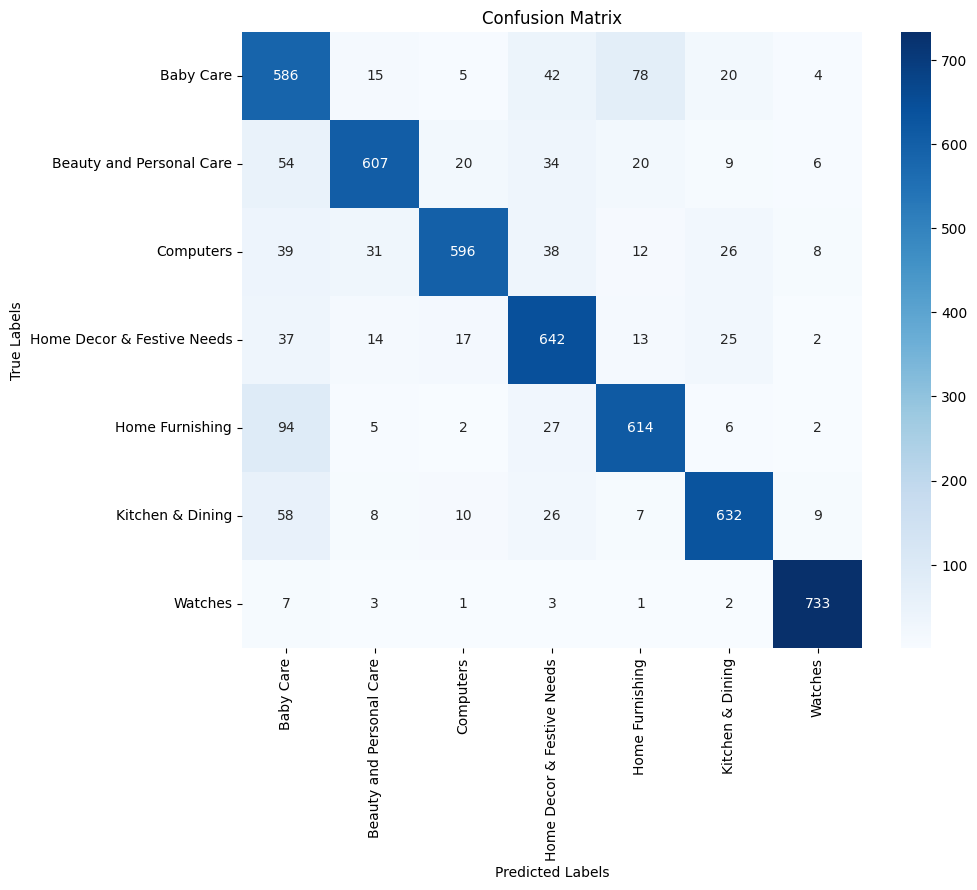

In [ ]:
# Configuration du générateur de données pour les données de test (sans augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Charger les données de test
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_augmented_images,            
    directory=None,                 
    x_col="augmented_image_path",            
    y_col="first_category",                  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False                   
)

# Prédictions du modèle sur les données de test
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Vrais labels (y_true) pour la comparaison
y_true = test_generator.classes

# Calcul des métriques
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [26]:

fine_tuned_model = load_model('model_VGG16/VGG16_fine_tuned.h5')

# Créer un modèle tronqué qui prend les mêmes entrées mais sort les caractéristiques avant la dernière couche de classification
feature_extractor = Model(inputs=fine_tuned_model.input, outputs=fine_tuned_model.layers[-2].output)

# Vérifier l'architecture du modèle d'extraction de caractéristiques
print(feature_extractor.summary())

# Extraire les caractéristiques des images en utilisant le modèle d'extraction de caractéristiques
images_features = []
i = 0

for image_file in df_product_clean["image"]:
    if i % 100 == 0:
        print(f"Processing image {i}")
    i += 1
    
    # Charger et prétraiter l'image
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    # Extraire les caractéristiques avec le modèle tronqué
    features = feature_extractor.predict(image, verbose=0)[0]
    images_features.append(features)

# Convertir la liste de caractéristiques en tableau NumPy
images_features = np.asarray(images_features)
print("Shape of extracted features:", images_features.shape)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,170,368 (80.76 MB)

 Trainable params: 13,535,104 (51.63 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None
Processing image 0
Processing image 100
Processing image 200
Processing image 300
Processing image 400
Processing image 500
Processing image 600


/usr/local/lib/python3.12/site-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processing image 700
Processing image 800
Processing image 900
Processing image 1000
Shape of extracted features: (1050, 128)


#### Réduction des dimmension ACP


In [27]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
acp = PCA(n_components=0.99)
X_img_acp = acp.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", X_img_acp.shape)

Dimensions dataset avant réduction PCA :  (1050, 128)
Dimensions dataset après réduction PCA :  (1050, 53)


#### Analyse visuel via T-SNE

##### affichage T-SNE selon catégories d'images

/usr/local/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


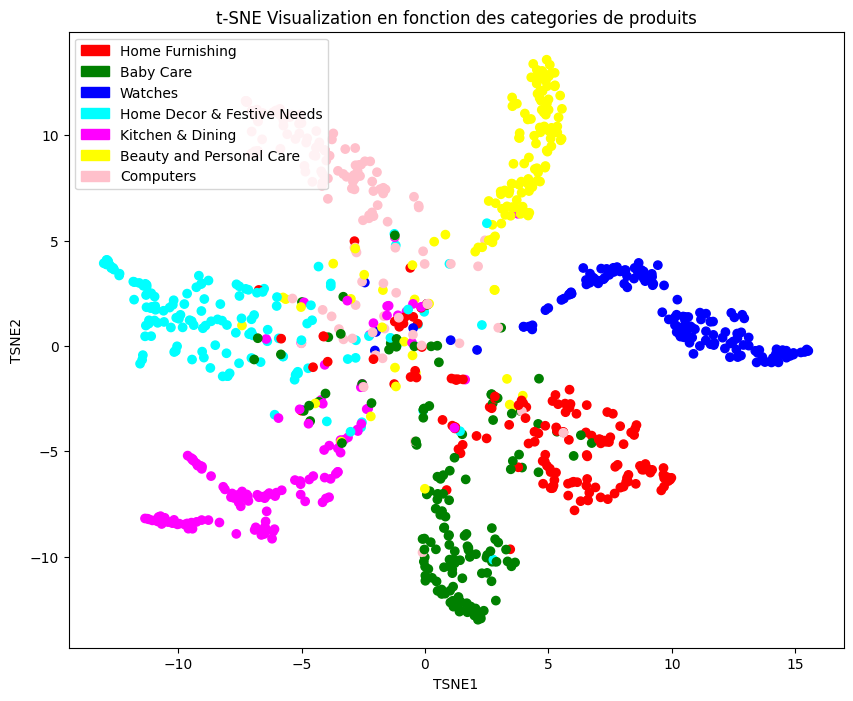

In [28]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_img_acp)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_img_fine_tuned"] = tsne_results[:, 0]
df_product_clean["TSNE2_category_img_fine_tuned"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_img_fine_tuned"],
    df_product_clean["TSNE2_category_img_fine_tuned"],
    c=color_list,
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

##### Affichage des images selon les clusters 

In [29]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

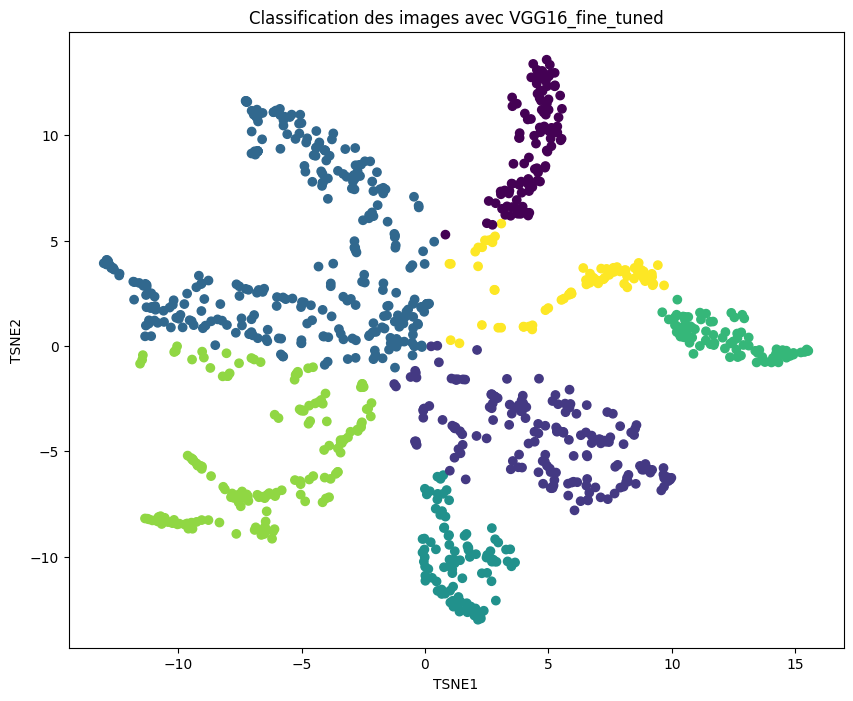

In [30]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["cluster_img_vgg16_fine_tuned"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_vgg16_fine_tuned"] = tsne_results[:, 0]
df_product_clean["TSNE2_vgg16_fine_tuned"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_vgg16_fine_tuned"],
    df_product_clean["TSNE2_vgg16_fine_tuned"],
    c=df_product_clean["cluster_img_vgg16_fine_tuned"],
)
plt.title("Classification des images avec VGG16_fine_tuned")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [31]:
clusters_labels = kmeans.labels_

In [33]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec VGG16 fine-tuné : {ari}")

Adjusted Rand Index (ARI) avec VGG16 fine-tuné : 0.44200529963672813
